<a href="https://colab.research.google.com/github/andreaaraldo/machine-learning-for-networks/blob/master/04.neural_networks/neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

# Use case description

The use case is from:

Khangura, S. K. (2019). Neural Network-based Available Bandwidth Estimation from TCP Sender-side Measurements. In IEEE/IFIP PEMWN.


**Goal** Estimate available bandwidth in a network via **passive measures**.

More precisely:
_Estimate the capacity available to a TCP flow_ (sharing links with other flows) observing
* The time gaps between segments sent $g_{\text{in}}$
* The gaps between acks $g_\text{ack}$

The auhtors set up the following testbed:


![alt text](https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/04.neural_networks/img/testbed.png)


Measures are collected in the **Video Receiver**. All the other machines just produce cross-traffic.

Measures are recorded via an Endace Data Acquisition and Generation (DAG) card, which timestamp all packets in an extremely precise way.

![alt text](https://www.endace.com/assets/images/products/DAG%209.5G4F_angled_small.png)

([Producer website](https://www.endace.com/endace-high-speed-packet-capture-solutions/oem/dag/))

**Why**: Knowing the available bandwidth, video streaming clients can properly choose the quality level to request.

# Traces

The description of the dataset can be found in the Appendix of Khangura's [PhD thesis](https://www.repo.uni-hannover.de/bitstream/handle/123456789/9219/Khangura_Sukhpreet_PhD_Thesis.pdf?sequence=3&isAllowed=y).

In [20]:
!wget https://www.ikt.uni-hannover.de/fileadmin/institut/Forschung/BandwidthEstimationTraces/BandwidthEstimationTraces.zip

--2020-03-15 11:31:38--  https://www.ikt.uni-hannover.de/fileadmin/institut/Forschung/BandwidthEstimationTraces/BandwidthEstimationTraces.zip
Resolving www.ikt.uni-hannover.de (www.ikt.uni-hannover.de)... 130.75.2.72
Connecting to www.ikt.uni-hannover.de (www.ikt.uni-hannover.de)|130.75.2.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 941822 (920K) [application/zip]
Saving to: ‘BandwidthEstimationTraces.zip.2’

BandwidthEstimation 100%[===================>] 919.75K   366KB/s    in 2.5s    

2020-03-15 11:31:41 (366 KB/s) - ‘BandwidthEstimationTraces.zip.2’ saved [941822/941822]



In [0]:
! unzip -o -q BandwidthEstimationTraces.zip

In [22]:
!ls BandwidthEstimationTraces

testing  training


Training and test datasets are separated

In [23]:
! ls BandwidthEstimationTraces/training

MultiLinkCapacity100   TightLinkafterBottleneckLink
SingleLinkCapacity100  TightLinkbeforeBottleneckLink
SingleLinkCapacity50


For simplicity, we will just consider the case with a single link between client and server, of total capacity C=100 Mbps (Ethernet level)

In [24]:
! ls BandwidthEstimationTraces/training/SingleLinkCapacity100

25_et_100_C_5_delta  50_et_100_C_5_delta  75_et_100_C_5_delta


There are three sets of traces:
* With cross traffic rate $\lambda$=25 Mbps
* With cross traffic rate $\lambda$=50 Mbps
* With cross traffic rate $\lambda$=75 Mbps

All rates are intended at the Ethernet level

In [29]:
! ls BandwidthEstimationTraces/training/SingleLinkCapacity100/75_et_100_C_5_delta

75_et_100_C_5_delta_100.csv  75_et_100_C_5_delta_55.csv
75_et_100_C_5_delta_10.csv   75_et_100_C_5_delta_56.csv
75_et_100_C_5_delta_11.csv   75_et_100_C_5_delta_57.csv
75_et_100_C_5_delta_12.csv   75_et_100_C_5_delta_58.csv
75_et_100_C_5_delta_13.csv   75_et_100_C_5_delta_59.csv
75_et_100_C_5_delta_14.csv   75_et_100_C_5_delta_5.csv
75_et_100_C_5_delta_15.csv   75_et_100_C_5_delta_60.csv
75_et_100_C_5_delta_16.csv   75_et_100_C_5_delta_61.csv
75_et_100_C_5_delta_17.csv   75_et_100_C_5_delta_62.csv
75_et_100_C_5_delta_18.csv   75_et_100_C_5_delta_63.csv
75_et_100_C_5_delta_19.csv   75_et_100_C_5_delta_64.csv
75_et_100_C_5_delta_1.csv    75_et_100_C_5_delta_65.csv
75_et_100_C_5_delta_20.csv   75_et_100_C_5_delta_66.csv
75_et_100_C_5_delta_21.csv   75_et_100_C_5_delta_67.csv
75_et_100_C_5_delta_22.csv   75_et_100_C_5_delta_68.csv
75_et_100_C_5_delta_23.csv   75_et_100_C_5_delta_69.csv
75_et_100_C_5_delta_24.csv   75_et_100_C_5_delta_6.csv
75_et_100_C_5_delta_25.csv   75_et_100_C_5_delta_7

Every experiment is repeated 100 times.

Let's check the trace of one experiment

In [73]:
filename = "BandwidthEstimationTraces/training/SingleLinkCapacity100/75_et_100_C_5_delta/75_et_100_C_5_delta_33.csv"
df = pd.read_csv(filename)
df

,100,25
0,1.00060,4.9907
1,0.99982,9.9443
2,1.00340,14.9910
3,1.01250,19.9870
4,1.09670,25.0280
5,1.10830,29.9820
6,1.27700,35.3180
7,1.27810,39.9750
8,1.24280,44.5390
9,1.42630,50.0520


The header is not a sample. It just tells us the scenario, i.e. total channel capacity (Mbps) and available bandwith (Mbps).

The columns are:
* $g_\text{in} / g_\text{ack}$
* Some sort of time stamp that we will ignore (not well described in the dataset)

Let's rename the columns to avoid ambiguity

In [74]:
df.columns=[['gap_ratio', 'timestamp']]
df.head()

,gap_ratio,timestamp
0,1.00060,4.9907
1,0.99982,9.9443
2,1.00340,14.9910
3,1.01250,19.9870
4,1.09670,25.0280


# Feature engineering

Each experiment will be a sample.

The features of a sample are the elements of the histogram of the first column

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faeff73aac8>]],
      dtype=object)

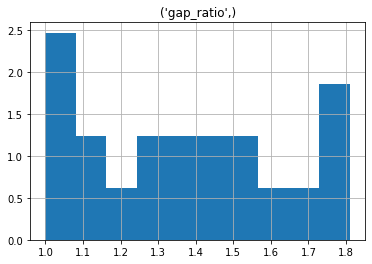

In [78]:
df[['gap_ratio']].hist(density=True, range=None)

# density:  True garantees that the area is 1 (such that hist approximates a 
#                 probability density function)

However, the sequence of bins is chosen automatically by `matplotlib` and may change from an experiment to another.

We need instead to describe all the experiments with a uniform set of features => The sequence of bins must be the same for all the experiments.

To do so:
* Take the min and max gap from all the experiments
* Divide the [min,max] interval uniformly

In [0]:
min_gap = inf
max_gap = -inf
for cross_traf in ['25', '50', '75']:
  filename = "BandwidthEstimationTraces/training/SingleLinkCapacity100/" +
              cross_traf + "_et_100_C_5_delta/"+
              cross_traf + "75_et_100_C_5_delta_33.csv"
  df = pd.read_csv(filename)
  df.columns=[['gap_ratio', 'timestamp']]
  df['gap_']

Add a label column, such that:
* label = 'low' if available bandwith = 25Mbps
* label = 'mid' if available bandwith = 50Mbps
* label = 'hig' if available bandwith = 75Mbps

In [0]:
def process_df(df):

  #### Get the available bandwith
  avail_band = df.columns[1]
  avail_band = 'low' if avail_band=='25' \
        else 'mid' if avail_band=='50' \
        else 'hig' if avail_band=='75'\
        else 'unrecognized'

  if avail_band=='unrecognized':
    raise ValueError('Error in processing experiment with total capacity '+
        df.columns[0] + ' and available badwidth '+
        df.columns[1]+': The value of available bandwith is not valid')

  df['avail_band'] = avail_band


  # Ignore the second column 
  df = df.drop(df.columns[1], axis=1)

  # Rename of the first column
  df = df.rename(columns={df.columns[0]:'gap_ratio'})
  return df

In [68]:
df = process_df(df)
df

,gap_ratio,avail_band
0,1.00060,low
1,0.99982,low
2,1.00340,low
3,1.01250,low
4,1.09670,low
5,1.10830,low
6,1.27700,low
7,1.27810,low
8,1.24280,low
9,1.42630,low


# Limits of the work

* Only a finite set of available bandwidth values are used (25, 50, 75 Mbps). In reality, any value can occur => Need to extend the test and validation test with random bandwidth values.

In [40]:
   else raise ValueException('Value of bandwidth available = '+ df.columns[1]+' not valid')

SyntaxError: ignored